--- 1. Caricamento Dati ---


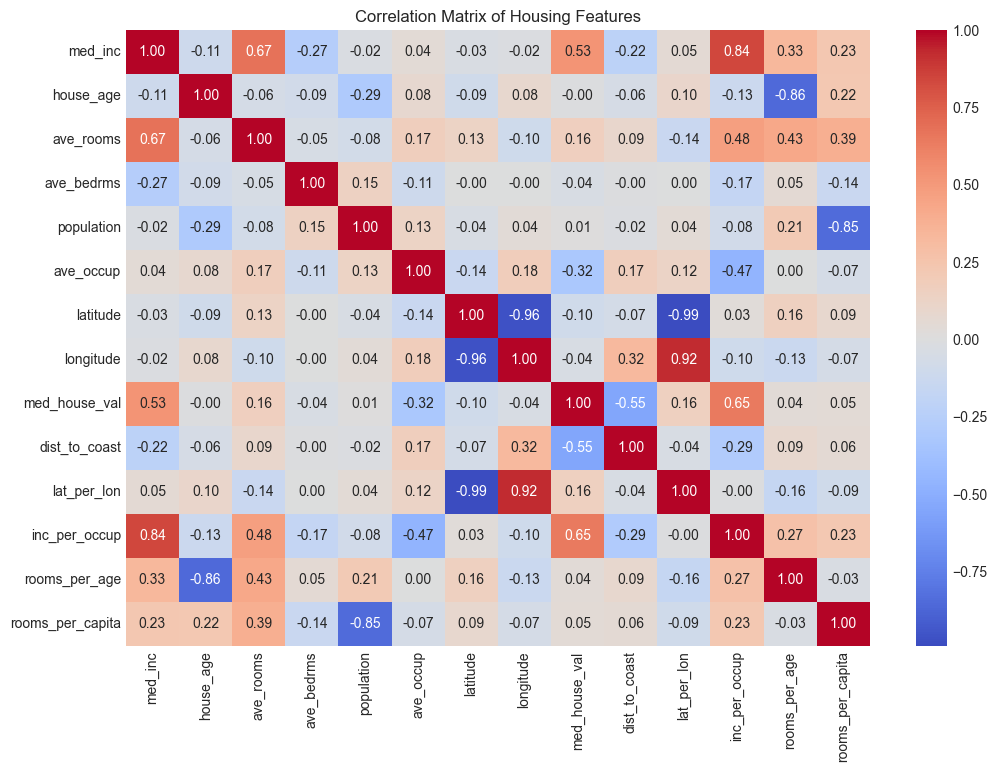

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Strumenti Scikit-Learn (Solo quelli studiati finora)
from sklearn.datasets import fetch_california_housing
from utils.base_data_handler import BaseDataHandler
from math import radians, sin, cos, sqrt, atan2

# Configurazione grafica
plt.style.use('seaborn-v0_8-whitegrid')

# ------------------------------------------------------------------------------
# FASE 1: Caricamento e Split Iniziale
# ------------------------------------------------------------------------------
print("--- 1. Caricamento Dati ---")
data = fetch_california_housing(as_frame=True)
df = data.frame

handler = BaseDataHandler(df=df)
handler.try_clean_column_names()

# Haversine distance (km)
# Fit a simple coastline curve: lon ≈ f(lat)
# Rough anchor pairs (lat, lon) along CA coast (north→south)
# Crescent City, Point Arena, SF outer coast, Monterey, Santa Barbara, LA, San Diego
_LAT = np.array([41.8, 39.0, 37.7, 36.6, 34.4, 34.0, 32.7])
_LON = np.array([-124.2, -123.7, -122.5, -121.9, -120.3, -118.5, -117.2])

# Quadratic fit: lon = a*lat^2 + b*lat + c
_COAST_COEFFS = np.polyfit(_LAT, _LON, deg=2)
def _coast_lon(lat):
    a, b, c = _COAST_COEFFS
    return a*lat*lat + b*lat + c

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1-a))

def coast_distance(lat, lon):
    coast_lon = _coast_lon(lat)
    return haversine(lat, lon, lat, coast_lon)

_ = handler.try_add_col(target_col="dist_to_coast", func=lambda row: coast_distance(row['latitude'],row['longitude']))
_ = handler.try_add_col(target_col="lat_per_lon", func=lambda row: row['latitude']/row['longitude'])
_ = handler.try_add_col(target_col="inc_per_occup", func=lambda row: row['med_inc']/row['ave_occup'])
_ = handler.try_add_col(target_col="rooms_per_age", func=lambda row: row['ave_rooms']/row['house_age'])
_ = handler.try_add_col(target_col="rooms_per_capita", func=lambda row: row['ave_rooms']/(row['population'])+1e-6)
_ = handler.try_add_col(target_col="age_per_dist", func=lambda row: row['house_age']/row['distance_to_coast'])

mask = handler.get_outliers_df(upper_percentile=.9)
handler.df = handler.df[~mask]
handler.try_update_og_df()
handler.og_df.dropna(inplace=True)
handler.try_reset_df()

# Compute correlation matrix
corr_matrix = handler.df.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Housing Features")
plt.show()

Test R²: 0.6679175240612818
Test RMSE: 0.40666045967764647


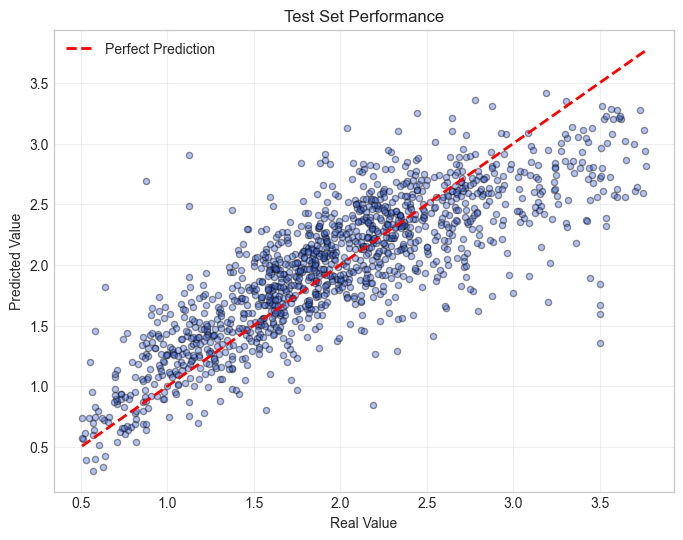


--- Influential Features ---
                         Feature         Weight     Abs_Weight
79          latitude lat_per_lon  216394.448525  216394.448525
76                    latitude^2  113551.034431  113551.034431
77            latitude longitude  107645.097860  107645.097860
94                 lat_per_lon^2   99487.881015   99487.881015
6                       latitude   95815.001545   95815.001545
85         longitude lat_per_lon   95815.001534   95815.001534
9                    lat_per_lon   77147.406997   77147.406997
7                      longitude   20386.707182   20386.707182
83                   longitude^2   16430.913132   16430.913132
8                  dist_to_coast    2373.395717    2373.395717
84       longitude dist_to_coast    2344.781865    2344.781865
90     dist_to_coast lat_per_lon    2344.267585    2344.267585
78        latitude dist_to_coast    2322.544719    2322.544719
95     lat_per_lon inc_per_occup   -1230.705673    1230.705673
80        latitude inc_pe

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split


""" handler.df.loc[:,'population_log'] = handler.df_log['population']
handler.df.loc[:,'ave_rooms_log'] = handler.df_log['ave_rooms']
handler.df.loc[:,'ave_bedrms_log'] = handler.df_log['ave_bedrms']
 """
dropped_features = ["med_house_val"]

# Define features and target
X = handler.df.drop(dropped_features, axis=1)
y = handler.df["med_house_val"]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Build polynomial regression pipeline
model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    StandardScaler(),
    LinearRegression()
)

# Train only on training set
model.fit(X_train, y_train)

# Predict on test set
y_pred_test = model.predict(X_test)
y_pred_test = np.clip(model.predict(X_test), 0, 5)

""" y_test = np.expm1(y_test)
y_pred_test = np.expm1(y_pred_test)
 """
# Metrics on test set
r2 = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("Test R²:", r2)
print("Test RMSE:", rmse)

# Diagnostic plot: Real vs Predicted on test set
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_test, alpha=0.4, color='royalblue', edgecolor='k', s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Real Value')
plt.ylabel('Predicted Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title("Test Set Performance")
plt.show()


# --- Weight Analysis ---
# Get feature names from PolynomialFeatures
poly = model.named_steps['polynomialfeatures']
linreg = model.named_steps['linearregression']

feature_names = poly.get_feature_names_out(X.columns)

# Build DataFrame of coefficients
coefs = pd.DataFrame({
    'Feature': feature_names,
    'Weight': linreg.coef_
})
coefs['Abs_Weight'] = coefs['Weight'].abs()

# Sort by absolute weight
top_features = coefs.sort_values(by='Abs_Weight', ascending=False).head(50)
print("\n--- Influential Features ---")
print(top_features)

In [3]:
handler.try_update_og_df()
handler.try_save_to_csv(name="california_housing_clean")

(True, None)